Want to: \
[1] run gphoton without FUV offset addition \
[2] run affine eclipse to calculate affine transformation \
[3] run gphoton again, applying affine transformation \
[4] make an image that shows effect of affine transformation on a square 

In [7]:
import matplotlib.pyplot as plt 
import pandas as pd
from pyarrow import parquet 
import numpy as np
import sys 
sys.path.append('/home/bekah/gPhoton2')
from gPhoton.pipeline import execute_pipeline
from astropy.io import fits
import os 
import cv2 

def affine_eclipse(eclipse): 
    # Find corresponding points 
    df = compare_bands(eclipse, f'/media/bekah/BekahA/eclipses_no_correction/e{eclipse}/')
    fuv_df = df[df["band"] == "fuv"]
    nuv_df = df[df["band"] == "nuv"]

    fuv_point_pairs = create_point_pairs_from_df(fuv_df)
    nuv_point_pairs = create_point_pairs_from_df(nuv_df)

    # first val is 'from', second is 'to'
    transformation_model = cv2.estimateAffinePartial2D(fuv_point_pairs, nuv_point_pairs, ransacReprojThreshold = .001)

    # apply the transformation to one of the images
    image = fits.open(f'/media/bekah/BekahA/eclipses_no_correction/e{eclipse}/e{eclipse}-fd-full-0-rice.fits')
    image1 = image[1].data
    aligned_image = cv2.warpAffine(image1, transformation_model[0], (image1.shape[1], image1.shape[0]))

    # write image 
    hdu = fits.CompImageHDU(aligned_image, compression_type='RICE_1')
    hdu.writeto(f'/media/bekah/BekahA/eclipses_no_correction/e{eclipse}/warped_e{eclipse}_affine.fits', overwrite=True)

    return transformation_model[0]

def create_point_pairs_from_df(df):
    # Extract columns as NumPy arrays
    ra = df["ra"].values
    dec = df["dec"].values
    
    # converting to pixels? 
    #ra = ra/1.5
    #dec = dec/1.5
    
    ra = ra * 2400
    dec = dec * 2400
    
    # Concatenate columns into a single array
    points = np.column_stack((ra, dec))
    
    # Reshape array to Nx2
    point_pairs = points.reshape(-1, 2)
    
    return point_pairs

def compare_bands(eclipse, eclipse_folder_path):

    e23330 = get_selected_sources(eclipse, eclipse_folder_path)

    color_mapping = {'nuv': 'red', 'fuv': 'blue'}

    e23330['Color'] = e23330['band'].map(color_mapping)

    # filter to middle of eclipse, change this 
    #selected_e23330 = e23330[(e23330['dec'] > -13.4) & (e23330['dec'] < -13.2) &
    #                           (e23330['ra'] > 354.2) & (e23330['ra'] < 354.4)]
    
    # Apply the function to each column
    
    #selected_e23330 = e23330
    selected_e23330 = filter_middle_30_percent(e23330)

    label_e23330 = dbscan_group(selected_e23330)
    
    e23330_matches = label_e23330[(label_e23330['Label'] > 1)]
    
    label_e23330 = label_e23330.rename(columns={"X": "ra", "Y": "dec"})

    merged = pd.merge(selected_e23330, label_e23330, on=['ra', 'dec'], how='inner', validate="one_to_one")
    
    merged = merged[(merged['Label'] > 1)]
    
    label_groups = merged.sort_values(by=['Label'])
    
    return label_groups 

def get_selected_sources(eclipse, folder):
    """ get central sources from both fuv and nuv for the same eclipse. returns concat
    pd df with sources from both bands. """
    
    nuv_list_name = f"e{eclipse}-nd-full-0-photom-12_8.csv"
    fuv_list_name = f"e{eclipse}-fd-full-0-photom-12_8.csv"
    nuv_image_name = f"e{eclipse}-nd-full-0-rice.fits"
    fuv_image_name = f"e{eclipse}-fd-full-0-rice.fits"

    nuvexists, nuvpath = check_file_in_folder(folder, nuv_list_name) 
    fuvexists, fuvpath = check_file_in_folder(folder, fuv_list_name) 

    if nuvexists & fuvexists: 
        nuv = pd.read_csv(nuvpath)  
        nuv['band'] = 'nuv'
        fuv = pd.read_csv(fuvpath) 
        fuv['band'] = 'fuv'
        
        fuvandnuv = pd.concat([nuv, fuv])

        return fuvandnuv 

def check_file_in_folder(folder_path, file_name):
    try:
        file_path = os.path.join(folder_path, file_name)
        if os.path.exists(file_path):
            return True, file_path
        else:
            return False
    except FileNotFoundError:
        print(f"The folder '{folder_path}' does not exist.")
    except PermissionError:
        print(f"Permission error accessing folder '{folder_path}'.")
    except Exception as e:
        print(f"An error occurred: {e}")
        
def dbscan_group(fuvandnuv): 
    from sklearn.cluster import DBSCAN

    fuvandnuv_xy = list(zip(fuvandnuv['ra'],fuvandnuv['dec']))
    dbscan = DBSCAN(eps=.001, min_samples=2)
    labels = dbscan.fit_predict(fuvandnuv_xy)
    points_with_labels = zip(fuvandnuv_xy, labels)
    
    labelsdf = pd.DataFrame(points_with_labels, columns=['Point', 'Label'])
    labelsdf[['X', 'Y']] = labelsdf['Point'].apply(lambda x: pd.Series({'X': x[0], 'Y': x[1]}))
    labelsdf = labelsdf.drop('Point', axis=1)
    return labelsdf 


def calculate_vector(group):
    group['dx'] = group['ra'].diff()
    group['dy'] = group['dec'].diff()
    group['size_diff'] = group['equivalent_radius'].diff()
    return group 

def filter_middle_50_percent(group):

    lower_bound_r = group['ra'].quantile(0.25)
    upper_bound_r = group['ra'].quantile(0.75)
    lower_bound_d = group['dec'].quantile(0.25)
    upper_bound_d = group['dec'].quantile(0.75)
    filtered = group[(group['ra'] >= lower_bound_r) & (group['ra'] <= upper_bound_r)
                    & (group['dec'] >= lower_bound_d) & (group['dec'] <= upper_bound_d)]
    
    return filtered

def filter_middle_30_percent(group):

    lower_bound_r = group['ra'].quantile(0.35)
    upper_bound_r = group['ra'].quantile(0.65)
    lower_bound_d = group['dec'].quantile(0.35)
    upper_bound_d = group['dec'].quantile(0.65)
    filtered = group[(group['ra'] >= lower_bound_r) & (group['ra'] <= upper_bound_r)
                    & (group['dec'] >= lower_bound_d) & (group['dec'] <= upper_bound_d)]
    
    return filtered

def make_affine_image(transformation_matrix, eclipse):
    
    # standard square for all eclipses 
    points = np.array([[.01,.01,1], [-.01,-.01,1], [-.01,.01,1], [.01,-.01,1]])

    points, transformed = apply_affine_transformation(transformation_matrix, points)
    
    plot_points(points, transformed, eclipse)
    
    return transformed
    
def apply_affine_transformation(transformation_matrix, points):
    #points = np.hstack((points, np.ones((points.shape[0], 1), dtype=np.float32)))
    # Apply affine transformation
    transformed_points = np.dot(transformation_matrix, points.T).T
    
    # Convert back to Cartesian coordinates
    #transformed_points = transformed_points[:, :2] / transformed_points[:, 2:]
    
    #transformed_points = cv2.perspectiveTransform(points, transformation_matrix)
    
    return points, transformed_points

def plot_points(original_points, transformed_points, eclipse):
    
    save_path = f'/media/bekah/BekahA/eclipses_no_correction/e{eclipse}/transformation_{eclipse}.jpg'
    
    plt.figure()
    plt.plot(original_points[:, 0], original_points[:, 1], 'ro', label='Original', markersize=5)
    plt.plot(transformed_points[:, 0], transformed_points[:, 1], 'bo', label='Affine', markersize=5)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'{eclipse} affine')
    plt.legend()
    plt.grid(True)
    plt.savefig(save_path)
    plt.close()
    
def plot_all_points(points_array, eclipse_list, save_path): 
    from matplotlib.cm import get_cmap
    #save_path = f'/media/bekah/BekahA/eclipses_no_correction/one_eclipse_transformed.jpg'
    
    plt.figure()
    original_points = np.array([[.01,.01,1], [-.01,-.01,1], [-.01,.01,1], [.01,-.01,1]])
        
    cmap = get_cmap('tab10')  
    
    for i, points in enumerate(points_array):
        color = cmap(i / len(points_array))
        plt.plot(points[:, 0], points[:, 1], 'o', color=color, markersize=5, label=eclipse_list[i])
    
    plt.plot(original_points[:, 0], original_points[:, 1], 'kx', label='Original', markersize=5)

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()
    
    
def get_affines_for_same_eclipse(eclipse):
    df = compare_bands(eclipse, f'/media/bekah/BekahA/eclipses_no_correction/e{eclipse}/')
    fuv_df = df[df["band"] == "fuv"]
    nuv_df = df[df["band"] == "nuv"]

    fuv_point_pairs = create_point_pairs_from_df(fuv_df)
    nuv_point_pairs = create_point_pairs_from_df(nuv_df)

    print(len(fuv_point_pairs))
    
    number_pairs = len(fuv_point_pairs)//6
    
    numbers = [i * 6 for i in range(number_pairs)]
    
    print(numbers)

    b = 0 
    transform_list = []
    eclipse_list = []
    while b < len(numbers)-1: 
        b = b+1 
        print(b)
        #transformation_model = cv2.estimateAffinePartial2D(fuv_point_pairs[numbers[b-1]:numbers[b]], 
        #                                                   nuv_point_pairs[numbers[b-1]:numbers[b]])
        transformation_model = cv2.estimateAffine2D(fuv_point_pairs[numbers[b-1]:numbers[b]], 
                                                           nuv_point_pairs[numbers[b-1]:numbers[b]])
        transformed = make_affine_image(transformation_model[0], eclipse)
        transform_list.append(transformed)
        eclipse_list.append(b)
        
    
    save_path = f'/home/bekah/glcat/fuv_offset/{eclipse}_full.jpg'
        
    plot_all_points(transform_list, eclipse_list, save_path)
    
    return 

In [ ]:
eclipses = ['00922','01910','02117','02188','02344','02372',
            '02477','02492','02506','23054','23062','23068',
           '23085','23154','23258','23328','23330','23331',
           '23334','23335','23336','23340']

transform_list = []
eclipse_list = []
for eclipse in eclipses: 
    try: 
        transformation_matrix = affine_eclipse(eclipse)
        transformed = make_affine_image(transformation_matrix, eclipse)
        transform_list.append(transformed)
        eclipse_list.append(eclipse)
    except:
        print("something went wrong")
        
plot_all_points(transform_list, eclipse_list, )

In [ ]:
eclipse = '02506'

transformation_matrix = affine_eclipse(eclipse)
make_affine_image(transformation_matrix, eclipse) 

In [ ]:
eclipse = '02506'
get_affines_for_same_eclipse(eclipse)

In [ ]:
eclipses = ['00922','01910','02117','02188','02344','02372',
            '02477','02492','02506','23054','23062','23068',
           '23085','23154','23258','23328','23330','23331',
           '23334','23335','23336','23340']

def scikit_affine_eclipse(eclipse): 
    # Find corresponding points 
    from skimage.transform import PiecewiseAffineTransform, warp

    df = compare_bands(eclipse, f'/media/bekah/BekahA/eclipses_no_correction/e{eclipse}/')
    fuv_df = df[df["band"] == "fuv"]
    nuv_df = df[df["band"] == "nuv"]

    fuv_point_pairs = create_point_pairs_from_df(fuv_df)
    nuv_point_pairs = create_point_pairs_from_df(nuv_df)

    print(len(nuv_point_pairs))
    tform = PiecewiseAffineTransform()
    tform.estimate(fuv_point_pairs, nuv_point_pairs)    
    
    # apply the transformation to one of the images
    image = fits.open(f'/media/bekah/BekahA/eclipses_no_correction/e{eclipse}/e{eclipse}-fd-full-0-rice.fits')
    image1 = image[1].data
    aligned_image = warp(image1, tform, output_shape=(image1.shape[1], image1.shape[0]))

    # write image 
    hdu = fits.CompImageHDU(aligned_image, compression_type='RICE_1')
    hdu.writeto(f'/media/bekah/BekahA/eclipses_no_correction/e{eclipse}/warped_e{eclipse}_scikit_affine.fits', overwrite=True)
    
    print(tform)
    return 


for eclipse in eclipses: 
    try: 
        scikit_affine_eclipse(eclipse)
    except:
        print("something went wrong")
    

In [8]:

from skimage.transform import PiecewiseAffineTransform, warp
eclipse = '02506'

df = compare_bands(eclipse, f'/media/bekah/BekahA/eclipses_no_correction/e{eclipse}/')
fuv_df = df[df["band"] == "fuv"]
nuv_df = df[df["band"] == "nuv"]

fuv_point_pairs = create_point_pairs_from_df(fuv_df)
nuv_point_pairs = create_point_pairs_from_df(nuv_df)

print(len(nuv_point_pairs))
tform = PiecewiseAffineTransform()
tform.estimate(fuv_point_pairs, nuv_point_pairs)    

# apply the transformation to one of the images
image = fits.open(f'/media/bekah/BekahA/eclipses_no_correction/e{eclipse}/e{eclipse}-fd-full-0-rice.fits')
image1 = image[1].data
aligned_image = warp(image1, tform, output_shape=(image1.shape[1], image1.shape[0]))
    
out_rows = image1.shape[1]
out_cols = image1.shape[0]


42


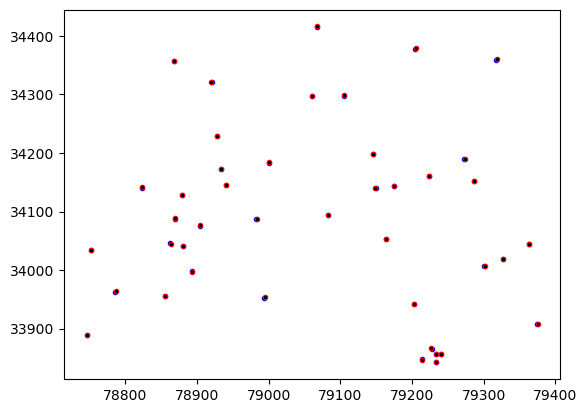

In [16]:
plt.plot(fuv_point_pairs[:,0], fuv_point_pairs[:,1], '.b')
plt.plot(nuv_point_pairs[:,0], nuv_point_pairs[:,1], '.r')
plt.plot(tform(fuv_point_pairs)[:, 0], tform(fuv_point_pairs)[:, 1], '*k',markersize=2)
plt.savefig( f'/home/bekah/glcat/fuv_offset/{eclipse}_scikit.png', dpi=1200)

In [ ]:
len(tform.affines)

In [ ]:
len(fuv_point_pairs)

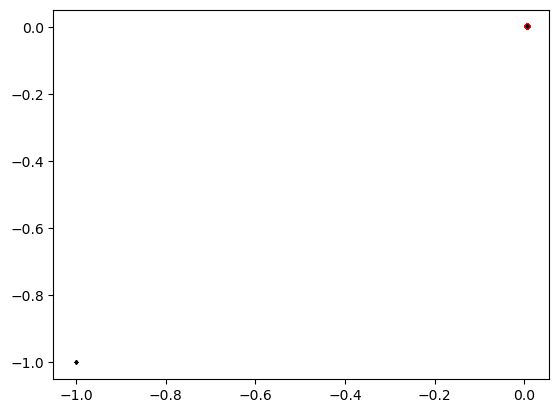

In [4]:
plt.plot(fuv_point_pairs[:,0], fuv_point_pairs[:,1], '.b')
plt.plot(nuv_point_pairs[:,0], nuv_point_pairs[:,1], '.r')
plt.plot(tform.inverse(fuv_point_pairs)[:, 0], tform.inverse(fuv_point_pairs)[:, 1], '*k',markersize=2)

In [10]:
nd = fits.open("/media/bekah/BekahA/eclipses_no_correction/e02506/e02506-nd-full-0-rice.fits")

In [11]:
fd = fits.open("/media/bekah/BekahA/eclipses_no_correction/e02506/e02506-fd-full-0-rice.fits")

In [12]:
nd[1].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / data type of original image                    
NAXIS   =                    2 / dimension of original image                    
NAXIS1  =                 3107 / length of original image axis                  
NAXIS2  =                 3133 / length of original image axis                  
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
XTENSION= 'BINTABLE'           / binary table extension                         
ZDITHER0=                 6817 / dithering offset when quantizing floats        
CDELT1  = -0.000416666666666667                                                 
CDELT2  = 0.000416666666666667                                                  
CTYPE1  = 'RA---TAN'                                                            
CTYPE2  = 'DEC--TAN'        

In [13]:
fd[1].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / data type of original image                    
NAXIS   =                    2 / dimension of original image                    
NAXIS1  =                 3084 / length of original image axis                  
NAXIS2  =                 3168 / length of original image axis                  
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
XTENSION= 'BINTABLE'           / binary table extension                         
ZDITHER0=                 8265 / dithering offset when quantizing floats        
CDELT1  = -0.000416666666666667                                                 
CDELT2  = 0.000416666666666667                                                  
CTYPE1  = 'RA---TAN'                                                            
CTYPE2  = 'DEC--TAN'        